In [ ]:
# 下载数据集
# 安装gdown
# 将Google Drive链接转换为可直接下载的格式
# 对于文件夹，需要先获取文件夹ID，然后下载其中的文件
import gdown
import os
import tarfile
# 数据集保存路径
root = "/IP102_v1.1"

# Google Drive 文件夹链接
folder_url = "https://drive.google.com/drive/folders/1svFSy2Da3cVMvekBwe13mzyx38XZ9xWo"

# 判断数据集是否已经存在
if os.path.exists(root) and os.listdir(root):
    print(f"数据集已存在，跳过下载解压: {root}")
else:
    print(f"开始下载数据集到: {root}")
    !gdown --folder "{folder_url}" -O "{root}"
    print("----开始解压数据集----")

    # 压缩包列表
    tar_files = [
        os.path.join(root, "Classification/ip102_v1.1.tar"),
        os.path.join(root, "Detection/VOC2007/Annotations.tar"),
        os.path.join(root, "Detection/VOC2007/JPEGImages.tar")
    ]

    # 解压函数
    def extract_tar(tar_path, output_dir=None):
        if output_dir is None:
            output_dir = os.path.dirname(tar_path)
        print(f"解压: {tar_path} → {output_dir}")
        with tarfile.open(tar_path, "r") as tar:
            tar.extractall(path=output_dir)
        print(f"✅ 完成: {tar_path}")

    # 遍历解压
    for tar_file in tar_files:
        extract_tar(tar_file)



开始下载数据集到: /content/IP102_v1.1
Retrieving folder contents
Retrieving folder 1ntmFAYessXYRLl8yuD_sPqdyPRtzxwyz Classification
Processing file 1kCHN6JKuK-3cSG5jGQQLRX94fAzAeCwPFH-ZsHfs5Jw classes
Processing file 1Xa3p1h8jkk7ECHzSuGYrn-d39QOd0ezj classes.txt
Processing file 1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN ip102_v1.1.tar
Retrieving folder 1ca6ZFuH6rube8VuZs4fgvj8WcF2QybFa Detection
Retrieving folder 10CHsTTFbZJBoAbbZwrJarKmPPqOgYYlM VOC2007
Retrieving folder 1sXT77ht8NSkBCtbsKC9mgpoGWj5vSw68 ImageSets
Retrieving folder 1CkwWiRSkGi9LjStD0gIWd1IEBywRBz0h Main
Processing file 1E7qMewUPvcoKT_T9n7OnOZxX9D9yL38Q test.txt
Processing file 1MR85vLr5NKntY1oP8dMD5XCS8me0c4Ux trainval.txt
Processing file 1TV1jaAp-XwhDupy_xfy4XPcmSFUb83c8 Annotations.tar
Processing file 1w7Lr4MQf03uREysDMh5Tr1T2xjfSxhRz JPEGImages.tar
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1kCHN6JKuK-3cSG5jG

/tmp/ipython-input-1821399672.py:35: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=output_dir)


✅ 完成: /content/IP102_v1.1/Classification/ip102_v1.1.tar
解压: /content/IP102_v1.1/Detection/VOC2007/Annotations.tar → /content/IP102_v1.1/Detection/VOC2007
✅ 完成: /content/IP102_v1.1/Detection/VOC2007/Annotations.tar
解压: /content/IP102_v1.1/Detection/VOC2007/JPEGImages.tar → /content/IP102_v1.1/Detection/VOC2007
✅ 完成: /content/IP102_v1.1/Detection/VOC2007/JPEGImages.tar


In [1]:
import os
import xml.etree.ElementTree as ET
import shutil
from PIL import Image
import re

# -------------------------------
# 配置路径
# -------------------------------
dataset_root = "IP102_v1.1/Detection/VOC2007"
images_dir = os.path.join(dataset_root, "JPEGImages")
ann_dir = os.path.join(dataset_root, "Annotations")
sets_dir = os.path.join(dataset_root, "ImageSets", "Main")  # train.txt / test.txt

output_root = "IP102_YOLOv8"
train_dir = os.path.join(output_root, "train")
val_dir = os.path.join(output_root, "val")

# -------------------------------
# 官方 classes.txt 102 类（英文名称）
# -------------------------------


classes_name = [
    "rice leaf roller","rice leaf caterpillar","paddy stem maggot","asiatic rice borer",
    "yellow rice borer","rice gall midge","Rice Stemfly","brown plant hopper",
    "white backed plant hopper","small brown plant hopper","rice water weevil",
    "rice leafhopper","grain spreader thrips","rice shell pest","grub","mole cricket",
    "wireworm","white margined moth","black cutworm","large cutworm","yellow cutworm",
    "red spider","corn borer","army worm","aphids","Potosiabre vitarsis","peach borer",
    "english grain aphid","green bug","bird cherry-oataphid","wheat blossom midge",
    "penthaleus major","longlegged spider mite","wheat phloeothrips","wheat sawfly",
    "cerodonta denticornis","beet fly","flea beetle","cabbage army worm","beet army worm",
    "Beet spot flies","meadow moth","beet weevil","sericaorient alismots chulsky",
    "alfalfa weevil","flax budworm","alfalfa plant bug","tarnished plant bug",
    "Locustoidea","lytta polita","legume blister beetle","blister beetle",
    "therioaphis maculata Buckton","odontothrips loti","Thrips","alfalfa seed chalcid",
    "Pieris canidia","Apolygus lucorum","Limacodidae","Viteus vitifoliae","Colomerus vitis",
    "Brevipoalpus lewisi McGregor","oides decempunctata","Polyphagotars onemus latus",
    "Pseudococcus comstocki Kuwana","parathrene regalis","Ampelophaga","Lycorma delicatula",
    "Xylotrechus","Cicadella viridis","Miridae","Trialeurodes vaporariorum","Erythroneura apicalis",
    "Papilio xuthus","Panonchus citri McGregor","Phyllocoptes oleiverus ashmead",
    "Icerya purchasi Maskell","Unaspis yanonensis","Ceroplastes rubens","Chrysomphalus aonidum",
    "Parlatoria zizyphus Lucus","Nipaecoccus vastalor","Aleurocanthus spiniferus",
    "Tetradacus c Bactrocera minax","Dacus dorsalis(Hendel)","Bactrocera tsuneonis",
    "Prodenia litura","Adristyrannus","Phyllocnistis citrella Stainton",
    "Toxoptera citricidus","Toxoptera aurantii","Aphis citricola Vander Goot",
    "Scirtothrips dorsalis Hood","Dasineura sp","Lawana imitata Melichar",
    "Salurnis marginella Guerr","Deporaus marginatus Pascoe","Chlumetia transversa",
    "Mango flat beak leafhopper","Rhytidodera bowrinii white","Sternochetus frigidus",
    "Cicadellidae"
]
# 中文名
# classes_name = [
#     "稻纵卷叶螟", "稻叶毛虫", "稻秆潜蝇", "亚洲稻螟",
#     "黄稻螟", "稻瘿蚊", "稻秆蝇", "褐飞虱",
#     "白背飞虱", "灰飞虱", "稻水象甲",
#     "稻叶蝉", "禾谷蓟马", "稻壳害虫", "蛴螬", "蝼蛄",
#     "金针虫", "白缘蛾", "黑切根虫", "大切根虫", "黄切根虫",
#     "红蜘蛛", "玉米螟", "黏虫", "蚜虫", "葡萄金斑蛾", "桃蛀螟",
#     "麦长管蚜", "绿bug", "燕麦蚜", "麦穗蛾",
#     "麦大赤螨", "长腿红蜘蛛", "麦皮蓟马", "麦叶蜂",
#     "齿角蝇", "甜菜潜蝇", "跳甲", "菜青虫", "甜菜夜蛾",
#     "甜菜斑蝇", "草地螟", "甜菜象甲", "东方绢金龟",
#     "苜蓿叶象甲", "亚麻芽蛾", "苜蓿盲蝽", "牧草盲蝽",
#     "蝗总科", "绿芫菁", "豆芫菁", "斑芫菁",
#     "苜蓿斑蚜", "豆蓟马", "蓟马", "苜蓿籽蜂",
#     "东方菜粉蝶", "绿盲蝽", "刺蛾科", "葡萄根瘤蚜", "葡萄瘿螨",
#     "刘氏短须螨", "十星瓢萤叶甲", "茶黄螨",
#     "康氏粉蚧", "葡萄透翅蛾", "葡萄天蛾", "斑衣蜡蝉",
#     "葡萄虎天牛", "大青叶蝉", "盲蝽科", "温室粉虱", "葡萄斑叶蝉",
#     "柑橘凤蝶", "柑橘全爪螨", "柑橘锈螨",
#     "吹绵蚧", "矢尖蚧", "红蜡蚧", "褐圆蚧",
#     "黑点蚧", "橘鳞粉蚧", "黑刺粉虱",
#     "柑橘小实蝇", "橘大实蝇", "蜜柑大实蝇",
#     "斜纹夜蛾", "黄斑卷叶蛾", "柑橘潜叶蛾",
#     "柑橘木虱", "橘二叉蚜", "橘蚜",
#     "茶黄蓟马", "柑橘花蕾蛆", "碧蛾蜡蝉",
#     "碧蜡蝉", "芒果切叶象甲", "柑橘黑线麦蛾",
#     "芒果扁喙叶蝉", "芒果脊胸天牛", "芒果果核象甲",
#     "叶蝉科"
# ]

# 保存 classes.txt
os.makedirs(output_root, exist_ok=True)
with open(os.path.join(output_root, "classes.txt"), "w", encoding="utf-8") as f:
    for cls in classes_name:
        f.write(cls + "\n")

# -------------------------------
# 修复 XML 函数（保留第一个 <annotation> ... </annotation>）
# -------------------------------
def clean_xml(xml_file):
    with open(xml_file, "r", encoding="utf-8") as f:
        content = f.read()
    match = re.search(r"<annotation>.*</annotation>", content, re.DOTALL)
    if match:
        with open(xml_file, "w", encoding="utf-8") as f:
            f.write(match.group(0))
        return True
    return False

# -------------------------------
# YOLO 标签转换函数
# -------------------------------
def convert_xml_to_yolo(xml_file, img_w, img_h):
    try:
        tree = ET.parse(xml_file)
    except ET.ParseError:
        print(f"❌ XML 解析失败，尝试修复: {xml_file}")
        if not clean_xml(xml_file):
            print(f"❌ 修复失败，跳过: {xml_file}")
            return []
        tree = ET.parse(xml_file)
    root = tree.getroot()
    yolo_boxes = []
    for obj in root.findall("object"):
        cls_id = int(obj.find("name").text)
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        x_center = ((xmin + xmax) / 2) / img_w
        y_center = ((ymin + ymax) / 2) / img_h
        bw = (xmax - xmin) / img_w
        bh = (ymax - ymin) / img_h
        yolo_boxes.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}")
    return yolo_boxes

# -------------------------------
# 创建输出目录
# -------------------------------
for d in [train_dir, val_dir]:
    os.makedirs(os.path.join(d, "images"), exist_ok=True)
    os.makedirs(os.path.join(d, "labels"), exist_ok=True)

# -------------------------------
# 加载 train/test 列表
# -------------------------------
def load_image_list(txt_file):
    with open(txt_file, "r") as f:
        return [line.strip() + ".jpg" for line in f.readlines()]

train_list = load_image_list(os.path.join(sets_dir, "trainval.txt"))
val_list   = load_image_list(os.path.join(sets_dir, "test.txt"))

# -------------------------------
# 生成 YOLO 标签
# -------------------------------
for img_set, split_dir in zip([train_list, val_list], [train_dir, val_dir]):
    for img_name in img_set:
        img_path = os.path.join(images_dir, img_name)
        xml_path = os.path.join(ann_dir, img_name.replace(".jpg", ".xml"))
        if not os.path.exists(xml_path):
            print(f"⚠️ XML 文件不存在: {xml_path}")
            continue
        with Image.open(img_path) as im:
            w, h = im.size
        yolo_boxes = convert_xml_to_yolo(xml_path, w, h)
        if not yolo_boxes:
            continue
        label_path = os.path.join(split_dir, "labels", img_name.replace(".jpg", ".txt"))
        with open(label_path, "w") as f:
            f.write("\n".join(yolo_boxes))
        shutil.copy(img_path, os.path.join(split_dir, "images", img_name))

# -------------------------------
# 生成 data.yaml
# -------------------------------
data_yaml = f"""
train: {train_dir}/images
val: {val_dir}/images

nc: {len(classes_name)}
names: {classes_name}
"""

with open(os.path.join(output_root, "data.yaml"), "w", encoding="utf-8") as f:
    f.write(data_yaml.strip())

print(f"✅ 数据集已处理为 YOLO 格式 → {output_root}")


✅ 数据集已处理为 YOLO 格式 → IP102_YOLOv8


In [ ]:
# 安装 YOLOv8 官方库（如果未安装）
!pip install ultralytics -q

# -------------------------------
# 导入
# -------------------------------
from ultralytics import YOLO
import os

# -------------------------------
# 配置
# -------------------------------
data_yaml = "./IP102_YOLOv8/data.yaml"  # 数据集 YAML
output_dir = "./IP102_YOLOv8/runs"     # 保存模型 checkpoint
epochs = 30                                   # 训练轮数
batch_size = 16                               # 可根据显存调节
img_size = 640                                # 输入尺寸

# -------------------------------
# 创建 YOLO 模型（从头训练）
# -------------------------------
model = YOLO("yolov8n.pt")  # 也可选择 yolov8s.pt / yolov8m.pt

# -------------------------------
# 开始训练
# -------------------------------
model.train(
    data=data_yaml,
    epochs=epochs,
    batch=batch_size,
    imgsz=img_size,
    project=output_dir,
    name="IP102_detection",
    exist_ok=True,
    save_period=1,       # 每个 epoch 保存一次 checkpoint
    save=True,
    # 自动保存最佳模型
    # ultralytics >= 8.1 默认会保存 best.pt
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/IP102_YOLOv8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=Fa

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  62,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  76,  77,  78,  79,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79b7ceb324b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012


image 1/1 c:\Users\Jianxi\Desktop\PestYOLO\IP102_YOLOv8\val\images\IP102003079.jpg: 416x640 1 Cicadellidae, 46.8ms
Speed: 3.7ms preprocess, 46.8ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 640)


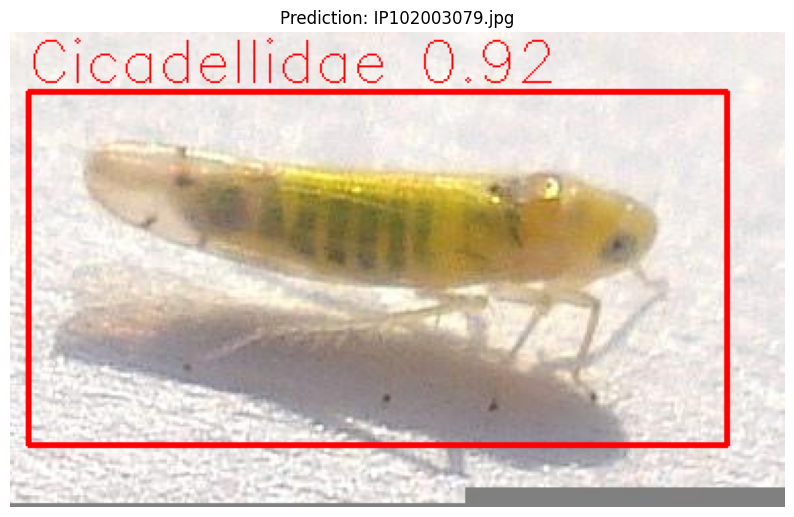

In [5]:
!pip install ultralytics
from ultralytics import YOLO
import os
import random
import matplotlib.pyplot as plt
import cv2

# -------------------------------
# 模型路径
# -------------------------------
best_model_path = "./IP102_YOLOv8/runs/IP102_detection/weights/best.pt"
model = YOLO(best_model_path)

# -------------------------------
# 验证集图片路径
# -------------------------------
val_img_dir = "./IP102_YOLOv8/val/images"
val_images = [f for f in os.listdir(val_img_dir) if f.endswith(".jpg")]

# 随机选择一张图片
img_name = random.choice(val_images)
img_path = os.path.join(val_img_dir, img_name)

# -------------------------------
# 预测
# -------------------------------
results = model.predict(
    source=img_path,   # 图片路径或文件夹
    imgsz=640,         # 输入尺寸
    conf=0.25,         # 置信度阈值
    show=False,        # 不用YOLO自带窗口显示
    save=False         # 不保存到磁盘
)

# -------------------------------
# 可视化结果
# -------------------------------
# YOLOv8 返回结果是 list，每个元素对应一张图片
result = results[0]

# 读取原图
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 绘制预测框和类别
for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    conf = float(box.conf[0])
    cls_id = int(box.cls[0])
    label = f"{model.names[cls_id]} {conf:.2f}"

    # 绘制矩形框
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1)

# 显示图片
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {img_name}")
plt.show()
